<a href="https://colab.research.google.com/github/AbdulmagedALKHULAIFI/Automatic-classifer-consumer-goods/blob/main/p6_2_IMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade pip

     |████████████████████████████████| 1.7 MB 8.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [3]:
# pip install --upgrade Pillow

In [4]:
pip install opencv-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 54.9 MB/s            
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
 pip install opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 1.2 MB/s            
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [6]:
!pip -y uninstall h5py
!pip -y uninstall keras
!pip -y uninstall tensorflow
!pip install tensorflow==1.13.1  
!pip install tensorflow-gpu==1.13.1
!pip install keras==2.2.4 
!pip install h5py==2.10.0


Usage:   
  pip <command> [options]

no such option: -y

Usage:   
  pip <command> [options]

no such option: -y

Usage:   
  pip <command> [options]

no such option: -y
     |████████████████████████████████| 92.6 MB 42 kB/s              
     |████████████████████████████████| 50 kB 8.6 MB/s             
     |████████████████████████████████| 3.2 MB 77.7 MB/s            
     |████████████████████████████████| 367 kB 78.9 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0
ERROR

In [7]:
# %tensorflow_version 1.8

In [8]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [9]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [10]:
!pip -y uninstall umap
!pip install umap-learn


Usage:   
  pip <command> [options]

no such option: -y
     |████████████████████████████████| 80 kB 5.3 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.1 MB 28.6 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=1a2225cf900235f908e6196f245bc0d3d82cd600ee3956c5c908d097606f03fa
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=7f2e0d8d5d0ff5979abce25f22f54590ed5fb63f63558dd785cb9a5c3ca20a0c
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [11]:
# !pip install -r requirements_pict.txt 

#Import

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn import preprocessing
from os import listdir
from matplotlib.image import imread
import random
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.manifold import trustworthiness

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.utils.linear_assignment_ import linear_assignment

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [13]:
#Variable globales
imgs_path = "/content/drive/MyDrive/OC/Projet 6/data/Images/"
preprocessed_imgs_path = '/content/drive/MyDrive/OC/Projet 6/data/preprocessed_images/'
list_photos = [file for file in listdir(imgs_path)]
print(len(list_photos))

1050


# To-do list

*   Correct the map (hot encoder) and the most predicted value



# Analyses exploratoires

In [14]:
data = pd.read_csv("/content/drive/MyDrive/OC/Projet 6/data/flipkart_com-ecommerce_sample_1050.csv")
data.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


#Nettoyage et préparation des données

In [15]:
data = data[['image',"product_category_tree"]].copy('deep')
data

,image,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1047,5912e037d12774bb73a2048f35a00009.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


Nous allons maintenant nous interesser aux catégories principaux des produits.

In [16]:
data['main_category'] = data.product_category_tree.str.split(">>",expand=True,)[0]
data['main_category'] = data['main_category'].str.replace(r'"', '')
data['main_category'] = data['main_category'].str.replace(r'[', '')
data['main_category'] = data['main_category'].str.replace(r']', '')
data.head(3)

,image,product_category_tree,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care


In [17]:
data = data.drop(axis=1,columns = 'product_category_tree')
data.head(3)

,image,main_category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care


Nous allons maintenant ajouté le chemin des images sur le drive. Vous pouvez le remplacer par l'addresse à votre convenance.

In [18]:
# path = imgs_path
# data['image'] = path + data['image'].astype(str)
# data.head(3)

## Etiquetage des images

In [19]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["main_category"])
data

,image,main_category,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


In [20]:
data.groupby("label").count()

,image,main_category
label,,
0,150,150
1,150,150
2,150,150
3,150,150
4,150,150
5,150,150
6,150,150


In [21]:
def list_images(name) :

    list_image_name = data[data['main_category']==name]
    return list_image_name.image.values

In [22]:
list_home_furnishing =list_images("Home Furnishing ")
list_baby_care=list_images("Baby Care ")
list_watches=list_images("Watches ")
list_home_decor_festive =list_images("Home Decor & Festive Needs ")
list_kitchen_dining =list_images("Kitchen & Dining ")
list_beauty_personal_care = list_images("Beauty and Personal Care ")
list_computers = list_images("Computers ")

## Affichage d'exemples des images par catégorie



Home furnishing
-------


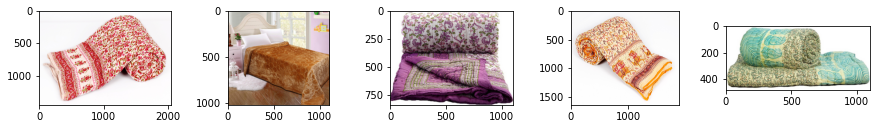



Baby care 
-------


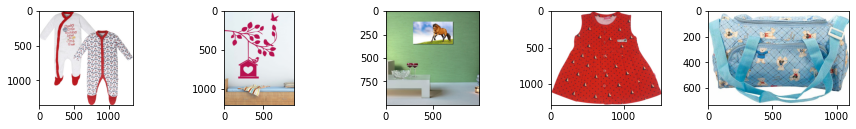



Watch
-------


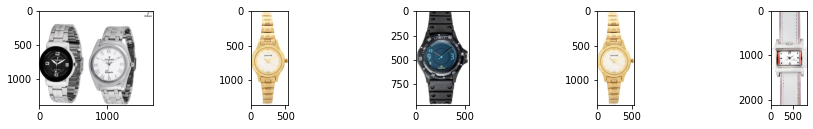



Home decoration and festivals
-------


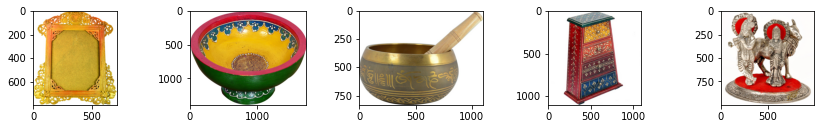



Kichen dinning
-------


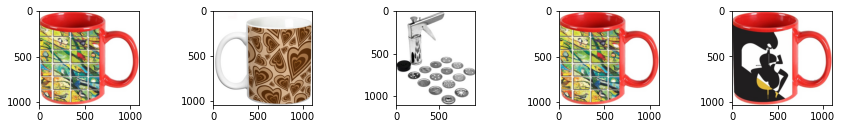



Beauty and personal care 
-------


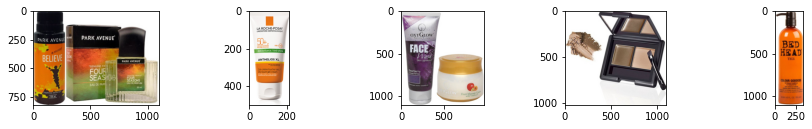



Computer
-------


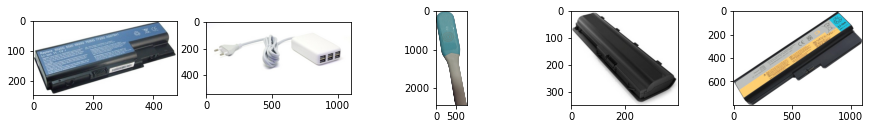

In [23]:

# creating a new dictionary
labels_dictionary ={
    "Home furnishing": list_home_furnishing ,
    "Baby care " : list_baby_care,
    "Watch" : list_watches,
    "Home decoration and festivals" : list_home_decor_festive ,
    "Kichen dinning" : list_kitchen_dining ,
    "Beauty and personal care " : list_beauty_personal_care ,
    "Computer" : list_computers}
 
# list out keys and values separately
key_list = list(labels_dictionary.keys())
val_list = list(labels_dictionary.values())

# print(key_list[0])

category_name_indice = 0

path = imgs_path

for category in val_list :

    print("\n\n"+key_list[category_name_indice])
    max_number_images_categories = len(category)-1
    print("-------")
    for i in range(5):
        plt.subplot(5,5,i+1)
        random_photo = random.randint(1, max_number_images_categories)
        filename = category.item(random_photo)
        filename = path + filename
        image = imread(filename)
        plt.imshow(image)

    category_name_indice = category_name_indice + 1
    plt.gcf().set_size_inches(15, 10)
    plt.show()

In [24]:
def resize_image(img, size, interpolation):
    """Function to resize image without deformation."""
    
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h 
    else:     dif = w
        
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    
    if c is None:
        # mask = np.zeros((dif, dif), dtype=img.dtype)
        mask = np.full((dif, dif), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        
    else:
        # mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask = np.full((dif, dif, c), fill_value=255, dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        
    return cv2.resize(mask, (size, size), interpolation)

In [25]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)


In [26]:
dir_read = imgs_path
dir_write = preprocessed_imgs_path

def preprocess_images():

  # for each product in the data
  for index, row in df_pict.iterrows():
      
      # get url of the product's image
      img_name = row['image']
      
      # create the path to the image file
      img_path = dir_read+img_name
      
      # Read the file and convert it to color image
      img_file = cv2.imread(img_path)
      img_rgb = cv2.cvtColor(img_file, cv2.COLOR_BGR2RGB)
      
      # resize the image to 224*224 pixels
      img_sqr = resize_image(img_rgb, size=224, interpolation=cv2.INTER_AREA)
      
      # auto-adjustment of contrast and luminosity
      img_preprocessed, alpha, beta = automatic_brightness_and_contrast(img_sqr)
      
      # save the preprocessed image
      img_preprocessed_path = dir_write+img_name
      cv2.imwrite(img_preprocessed_path, img_preprocessed)

# Pré-traitement des images

###  Pré-traitement des images via ORB

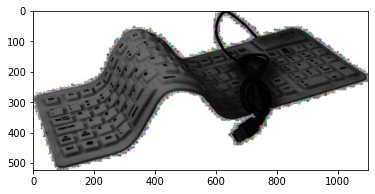

Descripteurs :  (500, 32)

[[166 172 166 ... 251 209 173]
 [ 94 164 246 ... 164  99 193]
 [102 136 198 ... 240  96   8]
 ...
 [ 54 108  70 ... 123  99 128]
 [118 165 196 ... 168 194   0]
 [116 172 198 ... 104  99 136]]


In [27]:
orb = cv2.ORB_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = orb.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


*   L'image contient 500 descripteurs
*   Chaque descripteur est un vecteur de longueur 32

#### Création de descriptions de chaque image


*   Pour chaque image passage en gris et equalisation
*   création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
*   création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs


In [28]:
preprocessed_imgs_path

'/content/drive/MyDrive/OC/Projet 6/data/preprocessed_images/'

In [29]:
orb_keypoints = []
temps1=time.time()
orb = cv2.ORB_create(500)

path = preprocessed_imgs_path

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all    = np.concatenate(orb_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (396075, 32)
temps de traitement ORB descriptor :           299.28 secondes


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Pré-traitement des images via SIFT

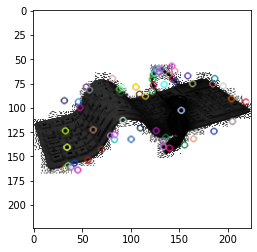

Descripteurs :  (69, 128)

[[ 1.  7. 89. ...  0.  0.  0.]
 [28.  4.  0. ...  0.  2. 40.]
 [47. 22.  6. ...  2.  3. 17.]
 ...
 [ 0.  1.  0. ...  0.  0. 43.]
 [27.  1.  0. ...  0.  0.  5.]
 [44.  4.  1. ...  0.  0.  0.]]


In [30]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(path+list_photos[1],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)


*   L'image contient 1464 descripteurs
*   Chaque descripteur est un vecteur de longueur 128



In [31]:
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (228871, 128)
temps de traitement SIFT descriptor :            15.61 secondes


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## Extraction des features par CNN

In [32]:
%%capture
from keras.layers import *
from keras.models import Sequential

from keras.applications import VGG16, ResNet50, InceptionV3

# getting the convolutional base of a ResNet50 CNN 
conv_base = ResNet50(weights='imagenet',
                      include_top=False, # remove the last layer
                      input_shape=(224,224,3),
                      )

### Creation of the cnn model to extract features

# add resnet50 convolutional base to our model
resnet_model = Sequential()
resnet_model.add(conv_base)


# add layer for dimensional reduction (global max pooling) 
resnet_model.add(GlobalMaxPooling2D())
### GlobalaveragePooling à tester


# print summary of the model
resnet_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
### Now defining dataloading Function
def extract_features(model,path,image_name, h, w,images_features):
    img = cv2.imread(path)
    img = cv2.resize(img, (h, w))
    ## Expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    # img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = model.predict(img)
    extractedFeatures = np.array(extractedFeatures)

    images_features.append(extractedFeatures.flatten())

In [34]:
def create_images_features(model,path):
    images_features = []
    
    list_ = data['image']
    for image_name in list_:
        full_name = path +  image_name
        extract_features(model,full_name,image_name, 224, 224,images_features)

    return images_features

In [35]:
resnet_images_features = create_images_features(resnet_model,preprocessed_imgs_path)

Maintentant nous allons utiliser le modèle VGG16

In [36]:
# getting the convolutional base of a VGG16
base_model_vgg16 = VGG16(weights='imagenet',
                      include_top=False, # remove the last layer
                      input_shape=(224,224,3),
                      )

### Creation of the cnn model to extract features

# add VGG convolutional base to our model
vgg_model = Sequential()
vgg_model.add(base_model_vgg16)


# add layer for dimensional reduction (global max pooling) 
vgg_model.add(GlobalMaxPooling2D())
### GlobalaveragePooling à tester


# print summary of the model
vgg_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [37]:
vgg_images_features = create_images_features(vgg_model,preprocessed_imgs_path)

In [38]:
#vgg_images_features

# Segementation des descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster.

In [39]:
def build_histogram(kmeans, des, image_num):
      res = kmeans.predict(des)
      hist = np.zeros(len(kmeans.cluster_centers_))
      nb_des=len(des)
      if nb_des==0 : print("problème histogramme image  : ", image_num)
      for i in res:
          hist[i] += 1.0/nb_des
      return hist

In [40]:
def create_images_features(keypoints_all, keypoints_by_img):

  # Determination number of clusters
  temps1=time.time()

  k = int(round(np.sqrt(len(keypoints_all)),0))
  print("Nombre de clusters estimés : ", k)
  print("Création de",k, "clusters de descripteurs ...")

  # Clustering
  kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
  kmeans.fit(keypoints_all)

  duration1=time.time()-temps1
  # print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")


  # Creation of histograms (features)
  temps1=time.time()

  # Creation of a matrix of histograms
  hist_vectors=[]

  for i, image_desc in enumerate(keypoints_by_img) :
      if i%100 == 0 : print(i)  
      hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
      hist_vectors.append(hist) #histogram is the feature vector

  im_features = np.asarray(hist_vectors)

  duration1=time.time()-temps1
  # print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

  return im_features

In [41]:
orb_img_features = create_images_features(orb_keypoints_all, orb_keypoints_by_img)

Nombre de clusters estimés :  629
Création de 629 clusters de descripteurs ...
0
100
200
300
400
500
600
700
800
900
1000


In [42]:
sift_img_features = create_images_features(sift_keypoints_all, sift_keypoints_by_img)

Nombre de clusters estimés :  478
Création de 478 clusters de descripteurs ...
0
100
200
300
400
500
600
700
800
900
1000


## Semgementation des image 

In [43]:
cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(vgg_images_features)

data["vgg_cluster"] = cls.labels_

In [44]:
cls.fit(resnet_images_features)

data["resnet_cluster"] = cls.labels_

In [45]:
cls.fit(sift_img_features)
data["sift_cluster"] = cls.labels_

In [46]:
cls.fit(orb_img_features)
data["orb_cluster"] = cls.labels_

In [47]:
# predict


# predictions = classifier.predict(X_test)

## Réductions de dimension


### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [48]:
def reduce_dimension_pca(img_features):
  print("Dimensions dataset avant réduction PCA : ", orb_img_features.shape)
  pca = decomposition.PCA(n_components=0.99)
  feat_pca= pca.fit_transform(img_features)
  print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

  return feat_pca

In [49]:
orb_feat_pca = reduce_dimension_pca(orb_img_features)

Dimensions dataset avant réduction PCA :  (1050, 629)
Dimensions dataset après réduction PCA :  (1050, 523)


In [50]:
sift_feat_pca = reduce_dimension_pca(sift_img_features)

Dimensions dataset avant réduction PCA :  (1050, 629)
Dimensions dataset après réduction PCA :  (1050, 406)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [51]:
def reduce_dimension_tsne(feat_pca):
  tsne = manifold.TSNE(n_components=2, perplexity=30, 
                      n_iter=2000, init='random', random_state=6)
  X_tsne = tsne.fit_transform(feat_pca)

  df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
  df_tsne["class"] = data["main_category"]
  print(df_tsne.shape)

  return df_tsne, X_tsne

In [52]:
orb_df_tsne, orb_X_tsne  = reduce_dimension_tsne(orb_feat_pca)

(1050, 3)


In [53]:
sift_df_tsne, sift_X_tsne  = reduce_dimension_tsne(sift_feat_pca)

(1050, 3)


Nous allons récupérer les features des images des modèles CNN d'un façon légerement différente.

In [54]:
vgg_features = np.array(vgg_images_features, dtype = 'float64')
vgg_dataframe = pd.DataFrame(vgg_features)

vgg_df_tsne, vgg_X_tsne  = reduce_dimension_tsne(vgg_dataframe)

(1050, 3)


In [55]:
resnet_features = np.array(resnet_images_features, dtype = 'float64')
resnet_dataframe = pd.DataFrame(resnet_features)

resnet_df_tsne, resnet_X_tsne  = reduce_dimension_tsne(resnet_dataframe)

(1050, 3)


In [56]:
# I saved resnet dataframe as it has the best performance. This result will be used in the combinaision of NLP and 
# Computer vision model to improve the prediction.  
resnet_dataframe.to_csv('/content/drive/MyDrive/OC/Projet 6/data/resnet_features_dataframe.csv',sep =',',index=False)

In [57]:
orb_df_tsne.head(3)

,tsne1,tsne2,class
0,3.660972,15.421411,Home Furnishing
1,-11.141218,-8.441559,Baby Care
2,11.219677,12.340746,Baby Care


In [58]:
sift_df_tsne.head(3)

,tsne1,tsne2,class
0,-2.323055,-13.583277,Home Furnishing
1,2.711638,5.392371,Baby Care
2,-5.012358,7.634608,Baby Care


In [59]:
vgg_df_tsne.head(3)

,tsne1,tsne2,class
0,2.725064,-16.107756,Home Furnishing
1,9.959705,-23.074579,Baby Care
2,18.457451,-18.316771,Baby Care


In [60]:
resnet_df_tsne.head(3)

,tsne1,tsne2,class
0,43.827076,14.858390,Home Furnishing
1,40.548374,-13.491554,Baby Care
2,33.528931,-1.645789,Baby Care


## Analyse visuelle : affichage T-SNE selon catégories d'images


In [61]:
def display_distrubtion(df_tsne):

  plt.figure(figsize=(13,9))
  sns.scatterplot(
      x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
      palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

  plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
  plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
  plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
  plt.legend(prop={'size': 14}) 

  plt.show()

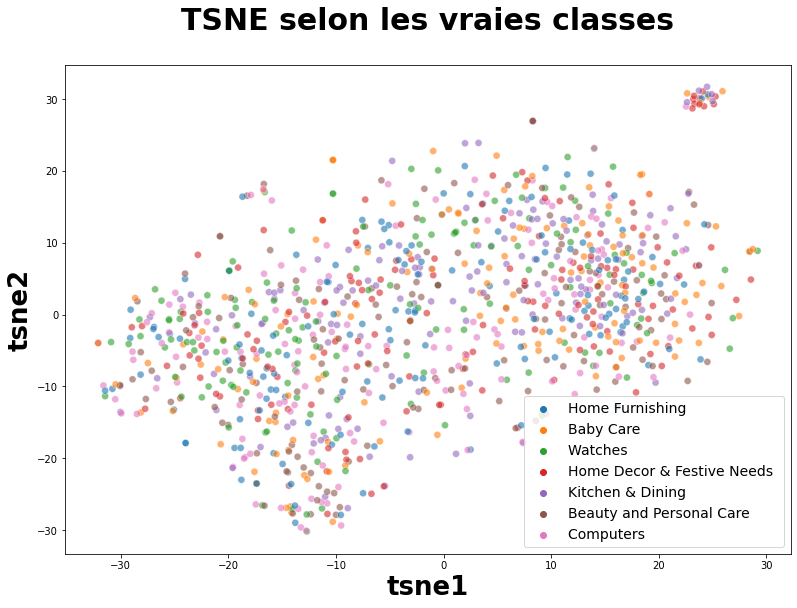

In [62]:
display_distrubtion(orb_df_tsne)

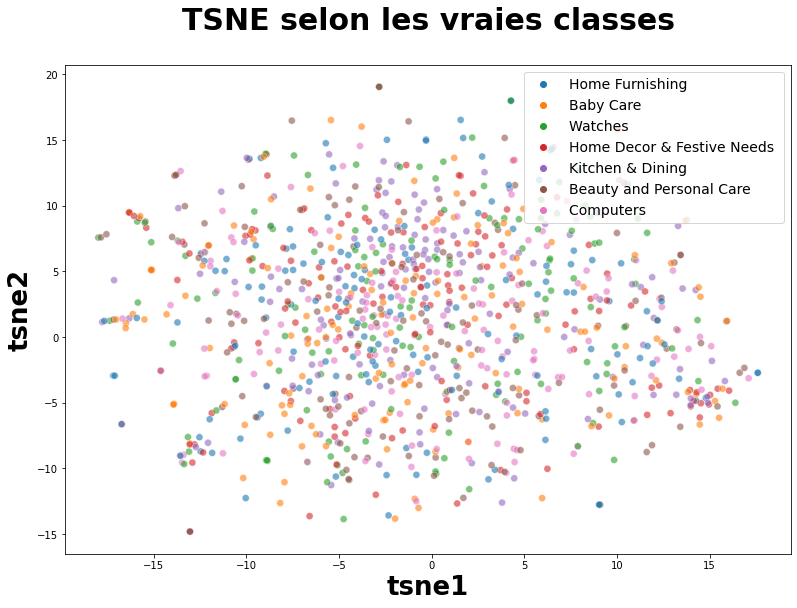

In [63]:
display_distrubtion(sift_df_tsne)

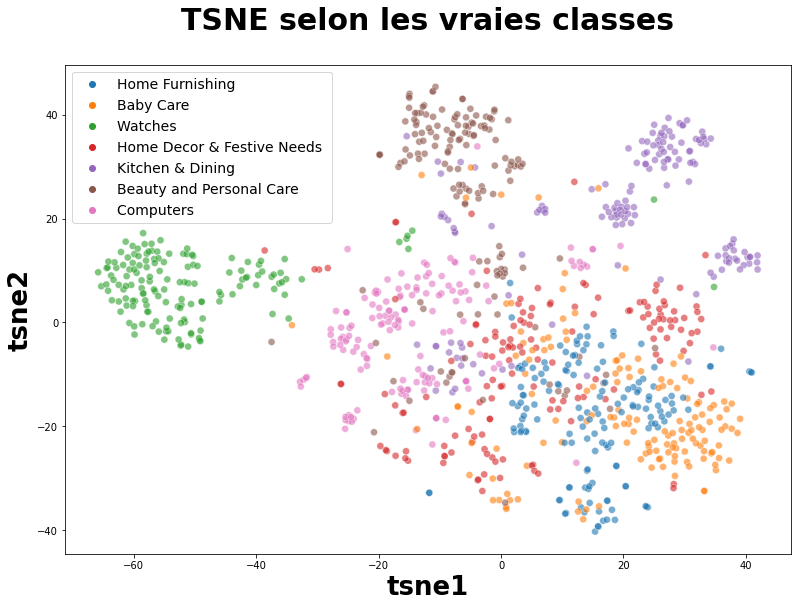

In [64]:
display_distrubtion(vgg_df_tsne)

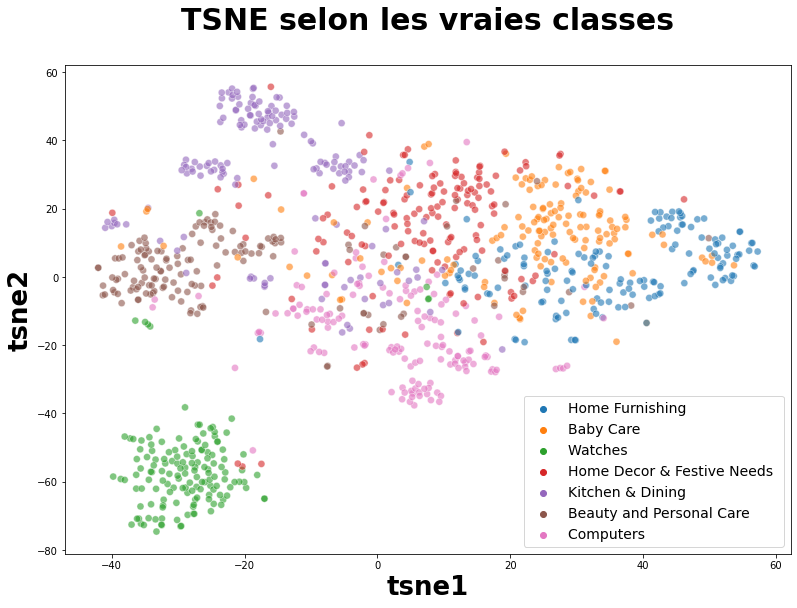

In [65]:
display_distrubtion(resnet_df_tsne)

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [66]:
def create_clusters(df_tsne,X_tsne):
  cls = cluster.KMeans(n_clusters=7, random_state=6)
  cls.fit(X_tsne)

  df_tsne["cluster"] = cls.labels_
  print(df_tsne.shape)
  return df_tsne

In [67]:
orb_df_tsne = create_clusters(orb_df_tsne,orb_X_tsne)

(1050, 4)


In [68]:
sift_df_tsne = create_clusters(sift_df_tsne,sift_X_tsne)

(1050, 4)


In [69]:
vgg_df_tsne = create_clusters(vgg_df_tsne,vgg_X_tsne)

(1050, 4)


In [70]:
resnet_df_tsne = create_clusters(resnet_df_tsne,resnet_X_tsne)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters


In [71]:
def display_clusters(df_tsne):
  plt.figure(figsize=(13,9))
  sns.scatterplot(
      x="tsne1", y="tsne2",
      hue="cluster",
      palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
      data=df_tsne,
      legend="brief")

  plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
  plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
  plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
  plt.legend(prop={'size': 14}) 

  plt.show()

  labels = data["label"]
  print("ARI : ", metrics.adjusted_rand_score(labels, df_tsne["cluster"]))

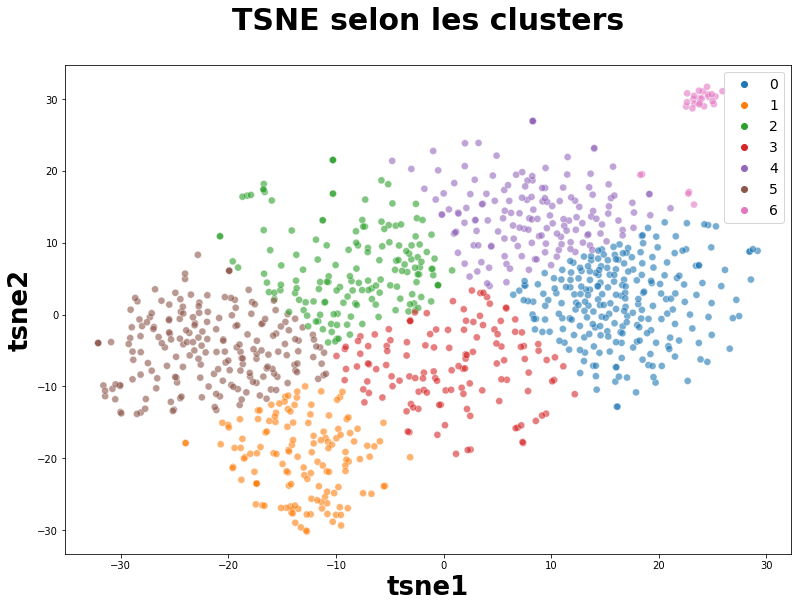

ARI :  0.007808301775369992


In [72]:
display_clusters(orb_df_tsne)

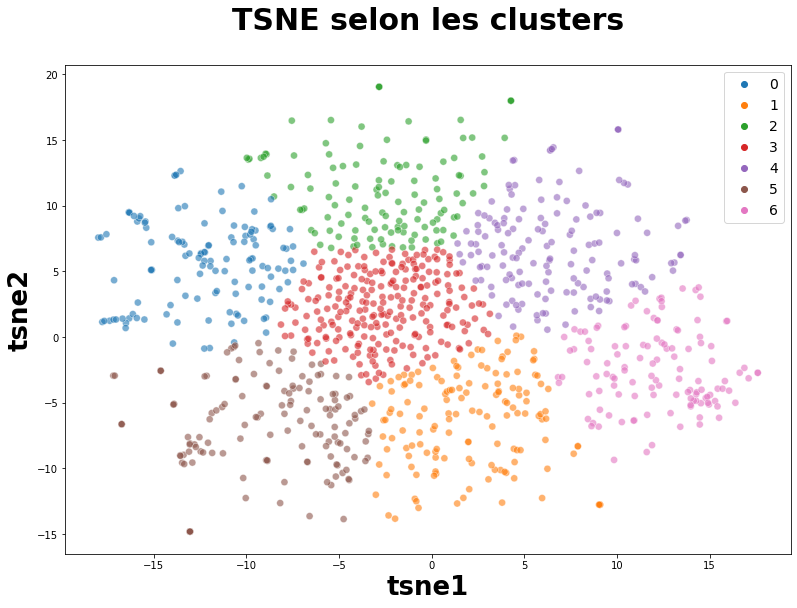

ARI :  0.0010982904603179882


In [73]:
display_clusters(sift_df_tsne)

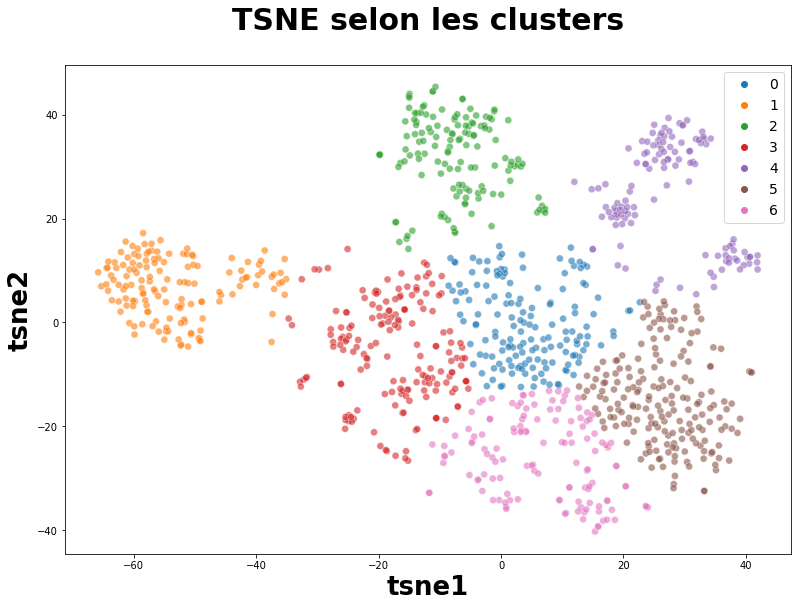

ARI :  0.4308638518702558


In [74]:
display_clusters(vgg_df_tsne)

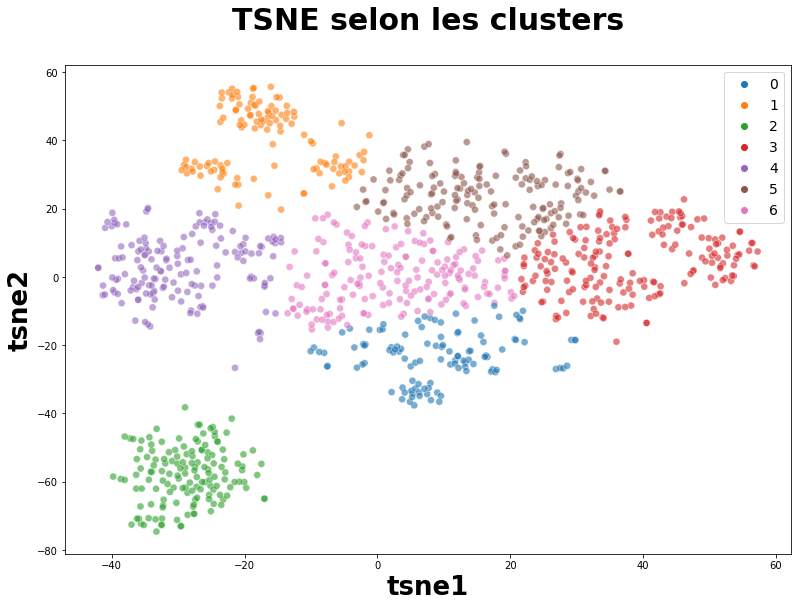

ARI :  0.4476009260428862


In [75]:
display_clusters(resnet_df_tsne)

# Evaluation

## Matrice de confusion


In [76]:
data.head(3)

,image,main_category,label,vgg_cluster,resnet_cluster,sift_cluster,orb_cluster
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,1,1,3,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,3,1,1,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,1,1,5,4


In [84]:
def plot_confusion_matrix(data,ct):
  #ploting the confusion matrix
  classes = data['class'].unique()
  fig, ax = plt.subplots()
  sns.heatmap(ct, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                  cbar=True)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
            yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  plt.xticks(rotation=90)
  plt.show()

In [78]:
#sorting confusion matrix with maximum value on the diagonal
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)


def create_confusion_matrix(data):
  #create cross table of the prediction
  ct = pd.crosstab(data['class'], data['cluster'])

  #sorting confusion matrix with maximum value on the diagonal
  indexes = linear_assignment(_make_cost_m(ct))
  js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
  ct = ct.reindex(js, axis="columns")

  return ct

In [82]:
vgg_cm = create_confusion_matrix(vgg_df_tsne)
resnet_cm = create_confusion_matrix(resnet_df_tsne)
orb_cm = create_confusion_matrix(orb_df_tsne)
sift_cm = create_confusion_matrix(sift_df_tsne)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


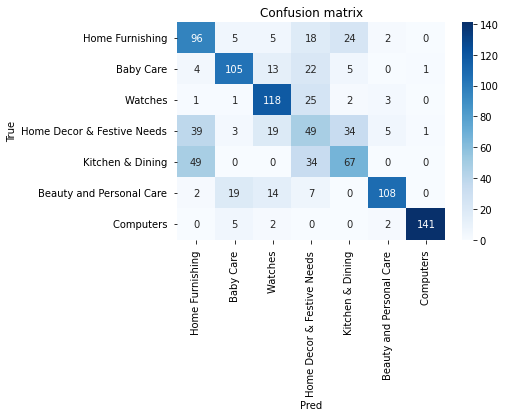

In [86]:
plot_confusion_matrix(vgg_df_tsne,vgg_cm) 

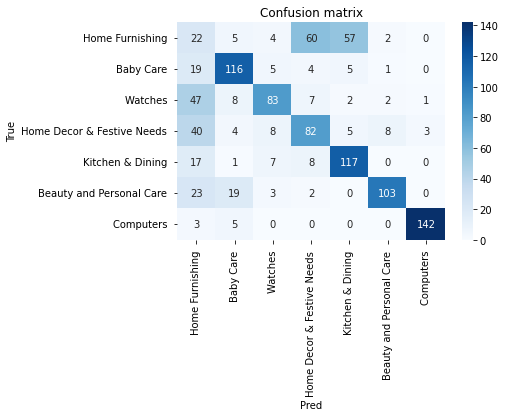

In [87]:
plot_confusion_matrix(resnet_df_tsne,resnet_cm)

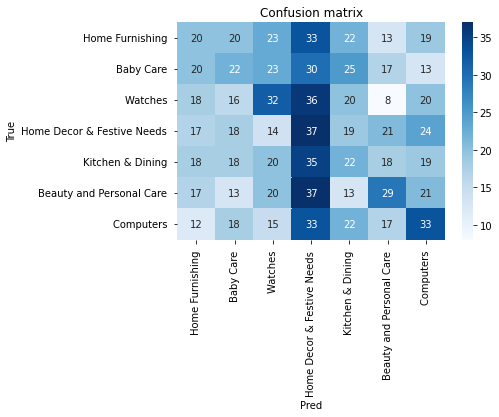

In [88]:
plot_confusion_matrix(sift_df_tsne,sift_cm)

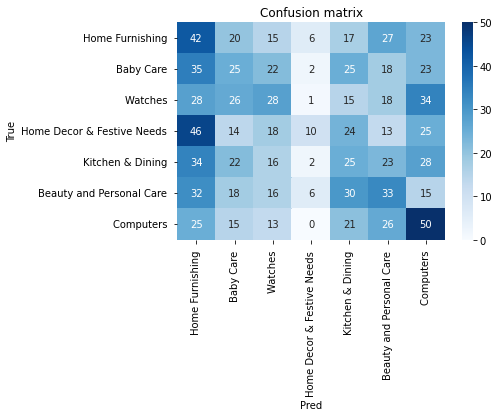

In [90]:
plot_confusion_matrix(orb_df_tsne,orb_cm)

## Tableau Comparatif

In [91]:
def predict_category(data,real_value, predict_value):
    
    #Keep only the cluster of the required extrater
    tmp_data = data[[ real_value ,predict_value]]    
    
    #Handle the categorical features
    dummy = pd.get_dummies(tmp_data[real_value])
    tmp_data = pd.concat([tmp_data,dummy],axis= 1)
    tmp_data.drop(real_value,axis = 1 , inplace = True)
    
    #count the prediction of each category
    confusion_matrix = tmp_data.groupby([predict_value]).sum()

    #indexing
    confusion_matrix['cluster_number'] = confusion_matrix.index;

    #remove defalut index
    confusion_matrix.reset_index(drop=True,inplace = True)

    #Get the most predicted category
    confusion_matrix['the_most_predicted_category'] = confusion_matrix.idxmax(axis=1)
    
    return confusion_matrix

In [92]:
def predict(source_data,forgien_key,new_predicted_column_name):

  most_predicted_values = predict_category(source_data,'main_category',forgien_key)

  source_data = pd.merge(source_data,most_predicted_values[['cluster_number','the_most_predicted_category']],
                      how ="left", left_on =forgien_key, right_on = 'cluster_number')
  
  source_data.drop(['cluster_number',forgien_key], axis=1,inplace= True)
  source_data.rename(columns={"the_most_predicted_category":new_predicted_column_name},inplace=True)

  return source_data

In [93]:
data.head(3)

,image,main_category,label,vgg_cluster,resnet_cluster,sift_cluster,orb_cluster
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,1,1,3,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,3,1,1,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,1,1,5,4


In [94]:
y=[1,1,1,2,2,2,3,3,3]
y1=[2,2,1,3,3,3,1,1,2]

In [95]:
y1

[2, 2, 1, 3, 3, 3, 1, 1, 2]

In [96]:
balanced_accuracy_score(y,y1)

0.1111111111111111

In [97]:
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [98]:
print(cluster_acc(np.array(y),np.array(y1)))


0.7777777777777778


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [99]:
data = predict(data,"sift_cluster","predicted_category_sift")
data = predict(data,"orb_cluster","predicted_category_orb")

data = predict(data,"resnet_cluster","predicted_category_resnet")
data = predict(data,"vgg_cluster","predicted_category_vgg")

In [100]:
data.head(3)

,image,main_category,label,predicted_category_sift,predicted_category_orb,predicted_category_resnet,predicted_category_vgg
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,Beauty and Personal Care,Baby Care,Home Furnishing,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0,Baby Care,Home Furnishing,Home Furnishing,Computers
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0,Home Decor & Festive Needs,Baby Care,Home Furnishing,Home Furnishing


In [132]:
Columns = ['Model', 'score ARI','Accuracy']
comparatif_table = pd.DataFrame(columns = Columns)

In [133]:
resnet_row = pd.DataFrame({"Model":["ResNet50"],
                    "score ARI":[adjusted_rand_score(data['main_category'],data['predicted_category_resnet'])],
                    "Accuracy": [np.trace(resnet_cm) / np.sum(resnet_cm).sum()]})  

In [134]:
vgg_row = pd.DataFrame({"Model":["VGG16"],
                    "score ARI":[adjusted_rand_score(data['main_category'],data['predicted_category_vgg'])],
                    "Accuracy": [np.trace(vgg_cm) / np.sum(vgg_cm).sum()]})  

In [135]:
sift_row = pd.DataFrame({"Model":["Sift"],
                    "score ARI":[adjusted_rand_score(data['main_category'],data['predicted_category_sift'])],
                    "Accuracy": [np.trace(sift_cm) / np.sum(sift_cm).sum()]})  

In [136]:
orb_row = pd.DataFrame({"Model":["Orb"],
                    "score ARI":[adjusted_rand_score(data['main_category'],data['predicted_category_orb'])],
                    "Accuracy": [np.trace(orb_cm) / np.sum(orb_cm).sum()]})  

In [137]:
result = comparatif_table.append([resnet_row, vgg_row,sift_row,orb_row])
result

,Model,score ARI,Accuracy
0,ResNet50,0.409991,0.633333
0,VGG16,0.358926,0.651429
0,Sift,0.006329,0.185714
0,Orb,0.006600,0.202857


## Affichage de certaines images predits

In [107]:
data.head(1)

,image,main_category,label,predicted_category_sift,predicted_category_orb,predicted_category_resnet,predicted_category_vgg
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4,Beauty and Personal Care,Baby Care,Home Furnishing,Home Furnishing


In [108]:
def list_images(column_name,category_name) :

    list_image_name = data[data[column_name]==category_name]
    return list_image_name.image.values

In [109]:
list_home_furnishing =list_images("predicted_category_resnet","Home Furnishing ")
list_baby_care=list_images("predicted_category_resnet","Baby Care ")
list_watches=list_images("predicted_category_resnet","Watches ")
list_home_decor_festive =list_images("predicted_category_resnet","Home Decor & Festive Needs ")
list_kitchen_dining =list_images("predicted_category_resnet","Kitchen & Dining ")
list_beauty_personal_care = list_images("predicted_category_resnet","Beauty and Personal Care ")
list_computers = list_images("predicted_category_resnet","Computers ")



Home furnishing
-------


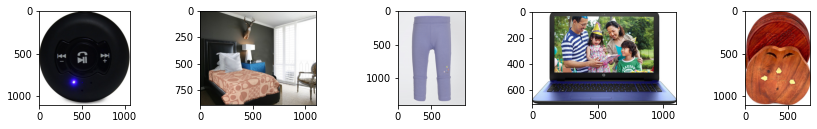



Baby care 
-------


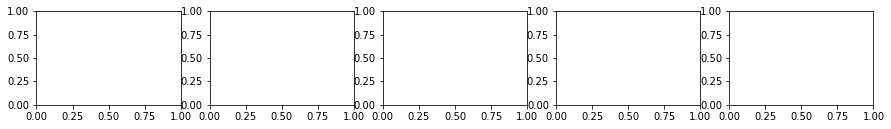



Watch
-------


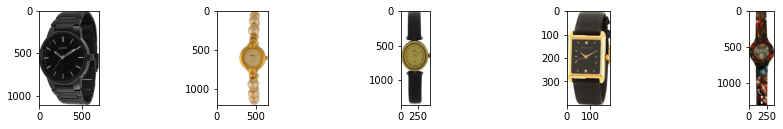



Home decoration and festivals
-------


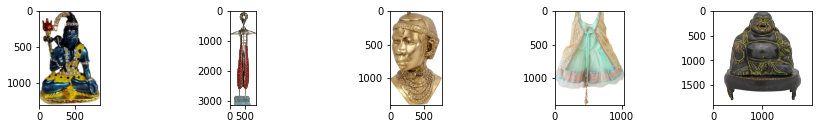



Kichen dinning
-------


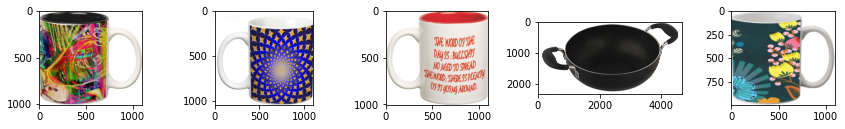



Beauty and personal care 
-------


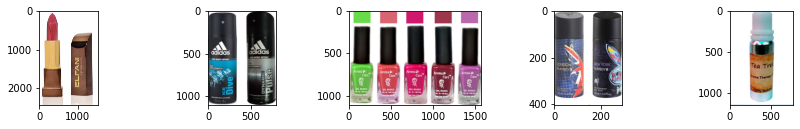



Computer
-------


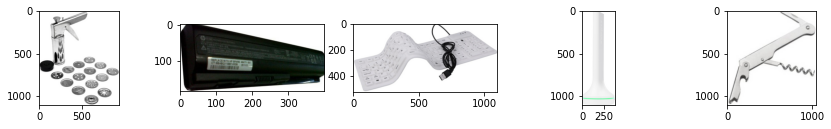

In [110]:
# creating a new dictionary
labels_dictionary ={
    "Home furnishing": list_home_furnishing ,
    "Baby care " : list_baby_care,
    "Watch" : list_watches,
    "Home decoration and festivals" : list_home_decor_festive ,
    "Kichen dinning" : list_kitchen_dining ,
    "Beauty and personal care " : list_beauty_personal_care ,
    "Computer" : list_computers}
 
# list out keys and values separately
key_list = list(labels_dictionary.keys())
val_list = list(labels_dictionary.values())

# print(key_list[0])

category_name_indice = 0

path = imgs_path

for category in val_list :

    print("\n\n"+key_list[category_name_indice])
    max_number_images_categories = len(category)-1
    print("-------")
    for i in range(5):
        plt.subplot(5,5,i+1)
        if(max_number_images_categories>5):
          random_photo = random.randint(1, max_number_images_categories)
          filename = category.item(random_photo)
          filename = path + filename
          image = imread(filename)
          plt.imshow(image)

    category_name_indice = category_name_indice + 1
    plt.gcf().set_size_inches(15, 10)
    plt.show()

# Choix de meilleur supervisé NLP + Computer Vision



In [111]:
data_cv = pd.read_csv('/content/drive/MyDrive/OC/Projet 6/data/resnet_features_dataframe.csv',sep =',')
data_cv.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.742697,4.648817,3.163346,0.158138,4.330797,4.894216,8.963379,1.418254,4.317201,8.427122,9.764009,-0.227763,3.739112,0.597997,2.414112,0.193797,-0.426277,4.369222,-0.258586,5.825557,3.198113,0.814037,-0.478716,0.658270,0.694859,1.344207,7.316513,0.458285,3.278512,0.857946,-0.054827,4.587070,7.256133,0.241600,11.174389,0.716946,4.049291,22.905630,0.839819,0.143315,...,1.524241,-0.374488,2.206531,2.669829,-1.471071,2.894167,0.401964,1.530607,0.387785,3.076328,2.319020,-0.621585,15.221767,1.465685,13.071238,-0.459014,-0.076031,0.365911,0.707419,0.314442,9.494921,-1.958560,1.498405,-1.762589,7.138740,4.628042,0.449083,-0.115371,0.148218,9.486592,2.968510,0.529875,6.680581,4.082518,5.044473,-0.967413,7.851311,0.229667,0.755632,2.659233
1,6.922855,-1.579462,5.522708,0.069097,5.387543,5.990954,1.741604,5.176549,2.732340,6.573298,6.224816,7.868954,14.994892,12.331205,1.658953,4.456892,-1.072954,-0.139643,2.501382,1.597498,8.598607,-1.015609,0.044881,3.248673,2.999759,2.741566,0.994071,-0.402637,4.008895,6.903923,3.326691,1.951907,1.237499,-0.954592,6.144794,2.523792,-1.524521,10.752689,-0.829637,-1.940286,...,1.005594,0.219078,-0.579197,5.803421,-0.080769,8.238154,0.522589,1.201178,-1.596152,11.131479,4.428228,13.796549,14.241621,-0.789900,15.458735,-0.681029,3.408148,1.983068,-0.887292,1.533515,9.341822,5.758866,0.404472,2.245388,2.534366,5.054527,-0.837771,8.449026,2.262032,12.389508,-0.850675,-0.334629,13.116744,2.317096,14.505166,3.609169,0.318384,-0.639284,1.633940,1.250218
2,-0.194296,-0.042895,1.672822,0.104871,8.515099,5.310872,9.553466,11.786600,1.322107,-0.924172,8.204498,2.648329,9.687328,1.214980,3.590341,4.900794,-0.704691,-0.942514,1.162310,1.061314,6.951754,1.716835,5.250658,4.993683,4.264782,1.919178,7.098913,3.079460,2.395860,1.004581,4.044559,0.202107,-0.130056,3.464728,7.506135,-0.319390,0.608227,9.105089,-0.517050,0.184321,...,2.875576,2.630738,8.399696,7.572518,-1.045772,6.522277,0.928488,-1.354047,-1.166893,0.024606,1.369734,2.372932,9.591370,1.639276,1.810097,1.966781,1.710343,5.602610,7.574220,3.746768,6.964500,1.396749,-0.504102,-1.903562,1.492251,6.628187,6.728354,-1.032053,0.625301,27.286228,1.873916,2.142696,0.803936,0.230481,4.331842,-0.684734,1.193557,1.460519,1.854570,5.894140


In [112]:
data_nlp = pd.read_csv('/content/drive/MyDrive/OC/Projet 6/data/cleaned_nlp_text.csv',sep=',')
data_nlp.head(3)

,main_cat,description,text_clean
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,key feature elegance polyester multicolor abst...
1,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,specification sathiyas cotton bath towel 3 bat...
2,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,key feature eurospa cotton terry face towel se...


## Traitement de données textuel

In [113]:
from sklearn.ensemble import RandomForestClassifier

tf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))
clf = RandomForestClassifier(max_depth=2, random_state=42)

In [114]:
df = data_nlp[['text_clean','main_cat']]
df.head(3)

,text_clean,main_cat
0,key feature elegance polyester multicolor abst...,Home Furnishing
1,specification sathiyas cotton bath towel 3 bat...,Baby Care
2,key feature eurospa cotton terry face towel se...,Baby Care


In [115]:
# Encode categorical target column
le = preprocessing.LabelEncoder()
df["label"] = le.fit_transform(df["main_cat"])
df.head(3)

,text_clean,main_cat,label
0,key feature elegance polyester multicolor abst...,Home Furnishing,4
1,specification sathiyas cotton bath towel 3 bat...,Baby Care,0
2,key feature eurospa cotton terry face towel se...,Baby Care,0


In [116]:
# X_train, X_test, y_train, y_test = train_test_split(df['text_clean'],df['label'], test_size=0.2,random_state=42)

In [117]:
tf_vectorizer.fit(df['text_clean'])
X = tf_vectorizer.transform(df['text_clean'])

In [118]:
## train classifier
# clf.fit(X_train, y_train)
clf.fit(X, df['label'])

## test
# tf_vectorizer.fit(X)
# X_test = tf_vectorizer.transform(X_test)

predicted_proba = clf.predict_proba(X)

Donc nous allons avoir un tableau de chaque avec  la probablité pour chaque categorie.

In [119]:
predicted_proba.shape

(1050, 7)

## Traitement de données visuels

Nous allons refaire le même manipluate que les données textuels afin de pouvoir un tableau avec la probabilité de chaque catégorie pour chaque article.

In [120]:
data_cv.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.742697,4.648817,3.163346,0.158138,4.330797,4.894216,8.963379,1.418254,4.317201,8.427122,9.764009,-0.227763,3.739112,0.597997,2.414112,0.193797,-0.426277,4.369222,-0.258586,5.825557,3.198113,0.814037,-0.478716,0.658270,0.694859,1.344207,7.316513,0.458285,3.278512,0.857946,-0.054827,4.587070,7.256133,0.241600,11.174389,0.716946,4.049291,22.905630,0.839819,0.143315,...,1.524241,-0.374488,2.206531,2.669829,-1.471071,2.894167,0.401964,1.530607,0.387785,3.076328,2.319020,-0.621585,15.221767,1.465685,13.071238,-0.459014,-0.076031,0.365911,0.707419,0.314442,9.494921,-1.958560,1.498405,-1.762589,7.138740,4.628042,0.449083,-0.115371,0.148218,9.486592,2.968510,0.529875,6.680581,4.082518,5.044473,-0.967413,7.851311,0.229667,0.755632,2.659233
1,6.922855,-1.579462,5.522708,0.069097,5.387543,5.990954,1.741604,5.176549,2.732340,6.573298,6.224816,7.868954,14.994892,12.331205,1.658953,4.456892,-1.072954,-0.139643,2.501382,1.597498,8.598607,-1.015609,0.044881,3.248673,2.999759,2.741566,0.994071,-0.402637,4.008895,6.903923,3.326691,1.951907,1.237499,-0.954592,6.144794,2.523792,-1.524521,10.752689,-0.829637,-1.940286,...,1.005594,0.219078,-0.579197,5.803421,-0.080769,8.238154,0.522589,1.201178,-1.596152,11.131479,4.428228,13.796549,14.241621,-0.789900,15.458735,-0.681029,3.408148,1.983068,-0.887292,1.533515,9.341822,5.758866,0.404472,2.245388,2.534366,5.054527,-0.837771,8.449026,2.262032,12.389508,-0.850675,-0.334629,13.116744,2.317096,14.505166,3.609169,0.318384,-0.639284,1.633940,1.250218
2,-0.194296,-0.042895,1.672822,0.104871,8.515099,5.310872,9.553466,11.786600,1.322107,-0.924172,8.204498,2.648329,9.687328,1.214980,3.590341,4.900794,-0.704691,-0.942514,1.162310,1.061314,6.951754,1.716835,5.250658,4.993683,4.264782,1.919178,7.098913,3.079460,2.395860,1.004581,4.044559,0.202107,-0.130056,3.464728,7.506135,-0.319390,0.608227,9.105089,-0.517050,0.184321,...,2.875576,2.630738,8.399696,7.572518,-1.045772,6.522277,0.928488,-1.354047,-1.166893,0.024606,1.369734,2.372932,9.591370,1.639276,1.810097,1.966781,1.710343,5.602610,7.574220,3.746768,6.964500,1.396749,-0.504102,-1.903562,1.492251,6.628187,6.728354,-1.032053,0.625301,27.286228,1.873916,2.142696,0.803936,0.230481,4.331842,-0.684734,1.193557,1.460519,1.854570,5.894140


In [121]:
#Insertion de la columun label de la vraie catégorie
data_cv.insert (0, "label", df["label"])
data_cv.head(3)

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,4,1.742697,4.648817,3.163346,0.158138,4.330797,4.894216,8.963379,1.418254,4.317201,8.427122,9.764009,-0.227763,3.739112,0.597997,2.414112,0.193797,-0.426277,4.369222,-0.258586,5.825557,3.198113,0.814037,-0.478716,0.658270,0.694859,1.344207,7.316513,0.458285,3.278512,0.857946,-0.054827,4.587070,7.256133,0.241600,11.174389,0.716946,4.049291,22.905630,0.839819,...,1.524241,-0.374488,2.206531,2.669829,-1.471071,2.894167,0.401964,1.530607,0.387785,3.076328,2.319020,-0.621585,15.221767,1.465685,13.071238,-0.459014,-0.076031,0.365911,0.707419,0.314442,9.494921,-1.958560,1.498405,-1.762589,7.138740,4.628042,0.449083,-0.115371,0.148218,9.486592,2.968510,0.529875,6.680581,4.082518,5.044473,-0.967413,7.851311,0.229667,0.755632,2.659233
1,0,6.922855,-1.579462,5.522708,0.069097,5.387543,5.990954,1.741604,5.176549,2.732340,6.573298,6.224816,7.868954,14.994892,12.331205,1.658953,4.456892,-1.072954,-0.139643,2.501382,1.597498,8.598607,-1.015609,0.044881,3.248673,2.999759,2.741566,0.994071,-0.402637,4.008895,6.903923,3.326691,1.951907,1.237499,-0.954592,6.144794,2.523792,-1.524521,10.752689,-0.829637,...,1.005594,0.219078,-0.579197,5.803421,-0.080769,8.238154,0.522589,1.201178,-1.596152,11.131479,4.428228,13.796549,14.241621,-0.789900,15.458735,-0.681029,3.408148,1.983068,-0.887292,1.533515,9.341822,5.758866,0.404472,2.245388,2.534366,5.054527,-0.837771,8.449026,2.262032,12.389508,-0.850675,-0.334629,13.116744,2.317096,14.505166,3.609169,0.318384,-0.639284,1.633940,1.250218
2,0,-0.194296,-0.042895,1.672822,0.104871,8.515099,5.310872,9.553466,11.786600,1.322107,-0.924172,8.204498,2.648329,9.687328,1.214980,3.590341,4.900794,-0.704691,-0.942514,1.162310,1.061314,6.951754,1.716835,5.250658,4.993683,4.264782,1.919178,7.098913,3.079460,2.395860,1.004581,4.044559,0.202107,-0.130056,3.464728,7.506135,-0.319390,0.608227,9.105089,-0.517050,...,2.875576,2.630738,8.399696,7.572518,-1.045772,6.522277,0.928488,-1.354047,-1.166893,0.024606,1.369734,2.372932,9.591370,1.639276,1.810097,1.966781,1.710343,5.602610,7.574220,3.746768,6.964500,1.396749,-0.504102,-1.903562,1.492251,6.628187,6.728354,-1.032053,0.625301,27.286228,1.873916,2.142696,0.803936,0.230481,4.331842,-0.684734,1.193557,1.460519,1.854570,5.894140


In [122]:
target_column = 'label'

X = data_cv.drop(axis=1,columns=target_column)
Y = data_cv[target_column]
Y.head(3)

0    4
1    0
2    0
Name: label, dtype: int64

In [123]:
# X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2,random_state=42)

In [124]:
# X_train.shape

In [125]:
clf.fit(X, Y)
predicted_proba_cv = clf.predict_proba(X)

In [126]:
predicted_proba_cv.shape

(1050, 7)

## Probablité combiné

In [127]:
def accuracy(y_true,y_pred):
    return np.mean(y_true == y_pred) 

def combain_probabilty(proba1,proba2):
  alpha = 0.0
  optimal_alpha = 0
  accuracy_score = 0

  for i in range(10):
      combaiend_proba = alpha * proba1 + (1-alpha) * proba2
      alpha = alpha + 0.1

      proba_df = pd.DataFrame(combaiend_proba)
      proba_df.insert(0,"label", df["label"])

      X_train, X_test, y_train, y_test = train_test_split(proba_df.drop(axis=1,columns='label'),
                                                          proba_df['label'], test_size=0.2,random_state=42,
                                                          stratify=proba_df['label'])
      
      clf.fit(X_train, y_train)
      predictions = clf.predict(X_test)

      if(accuracy(y_test, predictions) > accuracy_score):
        accuracy_score = accuracy(y_test, predictions)
        optimal_alpha = alpha

  return optimal_alpha, accuracy_score

In [128]:
alpha, score = combain_probabilty(predicted_proba,predicted_proba_cv)
print(alpha)

0.7


In [129]:
print(score)

0.8333333333333334


# Test